In [1]:
import importlib
import pydicom as dicom

import data
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pylab as plt
from PIL import Image
import numpy as np
import cv2
import pickle
import models
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score
importlib.reload(models)
importlib.reload(data)

<module 'data' from '/Users/amolmenon/Documents/Spring 2023/CMSC472/cmsc472_medicaldiagnosis/data.py'>

In [2]:
all_data = data.load_datasets()

train_set = all_data['combined']['train']
val_set = all_data['combined']['val']

In [3]:
batch_size = 32
learning_rate = 0.0001
epochs = 500

In [4]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [5]:
class MultiClassNet(nn.Module):

    def __init__(self, num_classes):
        super(MultiClassNet, self).__init__()
        self.procedure = nn.Sequential(
            nn.Linear(256 * 256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, 256 * 256)
        return self.procedure(x)

In [6]:
num_classes = len(all_data.keys()) - 1
model = MultiClassNet(num_classes)
optim = torch.optim.SGD(model.parameters(), lr = learning_rate) 
loss_function = nn.CrossEntropyLoss()

In [7]:
torch.manual_seed(42)


train_loss_epochs = []
val_loss_epochs = []
train_accs_epochs = []
val_accs_epochs = []

pixel_means = train_set.images.mean(dim=0, keepdim=True)
pixel_stds = train_set.images.std(dim=0, keepdim=True, unbiased=False)


for epoch in range(epochs):

    #Training phase
    model.train()  #Setting the model to train phase
    train_loss = []
    val_loss = []

    train_accs = []
    val_accs = []

    for idx, batch in enumerate(train_dataloader):

        x = batch[0]
        x = (x-pixel_means)/pixel_stds
        x = x.unsqueeze(1)
        y = batch[1].to(torch.float32)

        optim.zero_grad()
        out = model(x)
        loss = loss_function(out, y)
        loss.backward()
        optim.step()

        
        y_pred = F.one_hot(torch.argmax(out, dim=1), num_classes=num_classes)

        correct = (y_pred == y).sum().item() / num_classes
        train_acc = correct / y.size(0)



        #train_acc = torch.sum(torch.square(torch.sub(y, y_pred))).item() / (y.size(dim=0))
        #train_acc = (torch.squeeze(y_pred).eq(y)).sum().item() / y.size(dim=0)
        
        train_accs.append(train_acc)
        train_loss.append(loss.item())


    #Validation phase
    model.eval()  #Setting the model to eval mode, hence making it deterministic.
    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():   #Does not calulate the graidents, as in val phase its not needed. Saves on memory.
            x = batch[0]
            x = (x-pixel_means)/pixel_stds
            x = x.unsqueeze(1)
            y = batch[1].to(torch.float32)
            out = model.forward(x)
            loss = loss_function(out, y)
            
            y_pred = F.one_hot(torch.argmax(out, dim=1), num_classes=num_classes)
            
            correct = (y_pred == y).sum().item() / num_classes
            val_acc = correct / y.size(0)
            
            val_loss.append(loss.item())
            val_accs.append(val_acc)
    train_loss_epochs.append(np.mean(train_loss))
    val_loss_epochs.append(np.mean(val_loss))
    train_accs_epochs.append(np.mean(train_accs))
    val_accs_epochs.append(np.mean(val_accs))
    if epoch%1==0:
        print("Epoch : {}, Train loss: {:.5f} , Train Acc: {:.4f}, Val loss: {:.5f}, Val acc: {:.4f}".format(epoch, np.mean(train_loss), np.mean(train_acc), np.mean(val_loss), np.mean(val_acc)))
        
        

Epoch : 0, Train loss: 1.05771 , Train Acc: 1.0000, Val loss: 1.01984, Val acc: 1.0000
Epoch : 1, Train loss: 0.99922 , Train Acc: 1.0000, Val loss: 0.96046, Val acc: 1.0000
Epoch : 2, Train loss: 0.94308 , Train Acc: 1.0000, Val loss: 0.90888, Val acc: 1.0000
Epoch : 3, Train loss: 0.90378 , Train Acc: 1.0000, Val loss: 0.86792, Val acc: 1.0000
Epoch : 4, Train loss: 0.87923 , Train Acc: 0.7778, Val loss: 0.83627, Val acc: 1.0000
Epoch : 5, Train loss: 0.85529 , Train Acc: 0.7778, Val loss: 0.81021, Val acc: 1.0000
Epoch : 6, Train loss: 0.81660 , Train Acc: 1.0000, Val loss: 0.78942, Val acc: 1.0000
Epoch : 7, Train loss: 0.80565 , Train Acc: 1.0000, Val loss: 0.77230, Val acc: 1.0000
Epoch : 8, Train loss: 0.78351 , Train Acc: 1.0000, Val loss: 0.75803, Val acc: 1.0000
Epoch : 9, Train loss: 0.78323 , Train Acc: 1.0000, Val loss: 0.74577, Val acc: 1.0000
Epoch : 10, Train loss: 0.78531 , Train Acc: 0.5556, Val loss: 0.73585, Val acc: 1.0000
Epoch : 11, Train loss: 0.77134 , Train Ac

Epoch : 94, Train loss: 0.63308 , Train Acc: 1.0000, Val loss: 0.61313, Val acc: 1.0000
Epoch : 95, Train loss: 0.62852 , Train Acc: 1.0000, Val loss: 0.61289, Val acc: 1.0000
Epoch : 96, Train loss: 0.62970 , Train Acc: 1.0000, Val loss: 0.61265, Val acc: 1.0000
Epoch : 97, Train loss: 0.64309 , Train Acc: 0.7778, Val loss: 0.61247, Val acc: 1.0000
Epoch : 98, Train loss: 0.65859 , Train Acc: 0.5556, Val loss: 0.61232, Val acc: 1.0000
Epoch : 99, Train loss: 0.65901 , Train Acc: 0.5556, Val loss: 0.61217, Val acc: 1.0000
Epoch : 100, Train loss: 0.62740 , Train Acc: 1.0000, Val loss: 0.61192, Val acc: 1.0000
Epoch : 101, Train loss: 0.62753 , Train Acc: 1.0000, Val loss: 0.61171, Val acc: 1.0000
Epoch : 102, Train loss: 0.64228 , Train Acc: 0.7778, Val loss: 0.61152, Val acc: 1.0000
Epoch : 103, Train loss: 0.62655 , Train Acc: 1.0000, Val loss: 0.61132, Val acc: 1.0000
Epoch : 104, Train loss: 0.62542 , Train Acc: 1.0000, Val loss: 0.61112, Val acc: 1.0000
Epoch : 105, Train loss: 0.

Epoch : 187, Train loss: 0.61012 , Train Acc: 1.0000, Val loss: 0.59698, Val acc: 1.0000
Epoch : 188, Train loss: 0.61077 , Train Acc: 1.0000, Val loss: 0.59685, Val acc: 1.0000
Epoch : 189, Train loss: 0.61321 , Train Acc: 1.0000, Val loss: 0.59669, Val acc: 1.0000
Epoch : 190, Train loss: 0.62396 , Train Acc: 0.7778, Val loss: 0.59659, Val acc: 1.0000
Epoch : 191, Train loss: 0.60985 , Train Acc: 1.0000, Val loss: 0.59643, Val acc: 1.0000
Epoch : 192, Train loss: 0.60978 , Train Acc: 1.0000, Val loss: 0.59627, Val acc: 1.0000
Epoch : 193, Train loss: 0.62049 , Train Acc: 1.0000, Val loss: 0.59610, Val acc: 1.0000
Epoch : 194, Train loss: 0.62250 , Train Acc: 0.7778, Val loss: 0.59597, Val acc: 1.0000
Epoch : 195, Train loss: 0.60929 , Train Acc: 1.0000, Val loss: 0.59582, Val acc: 1.0000
Epoch : 196, Train loss: 0.60880 , Train Acc: 1.0000, Val loss: 0.59567, Val acc: 1.0000
Epoch : 197, Train loss: 0.62151 , Train Acc: 0.7778, Val loss: 0.59551, Val acc: 1.0000
Epoch : 198, Train lo

Epoch : 280, Train loss: 0.59608 , Train Acc: 1.0000, Val loss: 0.58399, Val acc: 1.0000
Epoch : 281, Train loss: 0.59669 , Train Acc: 1.0000, Val loss: 0.58385, Val acc: 1.0000
Epoch : 282, Train loss: 0.59518 , Train Acc: 1.0000, Val loss: 0.58373, Val acc: 1.0000
Epoch : 283, Train loss: 0.59503 , Train Acc: 1.0000, Val loss: 0.58360, Val acc: 1.0000
Epoch : 284, Train loss: 0.59569 , Train Acc: 1.0000, Val loss: 0.58350, Val acc: 1.0000
Epoch : 285, Train loss: 0.59771 , Train Acc: 1.0000, Val loss: 0.58337, Val acc: 1.0000
Epoch : 286, Train loss: 0.59470 , Train Acc: 1.0000, Val loss: 0.58325, Val acc: 1.0000
Epoch : 287, Train loss: 0.60139 , Train Acc: 1.0000, Val loss: 0.58311, Val acc: 1.0000
Epoch : 288, Train loss: 0.59402 , Train Acc: 1.0000, Val loss: 0.58299, Val acc: 1.0000
Epoch : 289, Train loss: 0.59996 , Train Acc: 1.0000, Val loss: 0.58285, Val acc: 1.0000
Epoch : 290, Train loss: 0.59542 , Train Acc: 1.0000, Val loss: 0.58273, Val acc: 1.0000
Epoch : 291, Train lo

Epoch : 373, Train loss: 0.58234 , Train Acc: 1.0000, Val loss: 0.57418, Val acc: 1.0000
Epoch : 374, Train loss: 0.58222 , Train Acc: 1.0000, Val loss: 0.57410, Val acc: 1.0000
Epoch : 375, Train loss: 0.58215 , Train Acc: 1.0000, Val loss: 0.57401, Val acc: 1.0000
Epoch : 376, Train loss: 0.58666 , Train Acc: 1.0000, Val loss: 0.57393, Val acc: 1.0000
Epoch : 377, Train loss: 0.58271 , Train Acc: 1.0000, Val loss: 0.57384, Val acc: 1.0000
Epoch : 378, Train loss: 0.58203 , Train Acc: 1.0000, Val loss: 0.57375, Val acc: 1.0000
Epoch : 379, Train loss: 0.58217 , Train Acc: 1.0000, Val loss: 0.57367, Val acc: 1.0000
Epoch : 380, Train loss: 0.58203 , Train Acc: 1.0000, Val loss: 0.57359, Val acc: 1.0000
Epoch : 381, Train loss: 0.58294 , Train Acc: 1.0000, Val loss: 0.57352, Val acc: 1.0000
Epoch : 382, Train loss: 0.58541 , Train Acc: 1.0000, Val loss: 0.57343, Val acc: 1.0000
Epoch : 383, Train loss: 0.58174 , Train Acc: 1.0000, Val loss: 0.57334, Val acc: 1.0000
Epoch : 384, Train lo

Epoch : 466, Train loss: 0.57383 , Train Acc: 1.0000, Val loss: 0.56776, Val acc: 1.0000
Epoch : 467, Train loss: 0.57420 , Train Acc: 1.0000, Val loss: 0.56770, Val acc: 1.0000
Epoch : 468, Train loss: 0.57726 , Train Acc: 1.0000, Val loss: 0.56765, Val acc: 1.0000
Epoch : 469, Train loss: 0.57601 , Train Acc: 1.0000, Val loss: 0.56760, Val acc: 1.0000
Epoch : 470, Train loss: 0.57345 , Train Acc: 1.0000, Val loss: 0.56755, Val acc: 1.0000
Epoch : 471, Train loss: 0.57377 , Train Acc: 1.0000, Val loss: 0.56750, Val acc: 1.0000
Epoch : 472, Train loss: 0.57366 , Train Acc: 1.0000, Val loss: 0.56744, Val acc: 1.0000
Epoch : 473, Train loss: 0.57345 , Train Acc: 1.0000, Val loss: 0.56739, Val acc: 1.0000
Epoch : 474, Train loss: 0.57334 , Train Acc: 1.0000, Val loss: 0.56734, Val acc: 1.0000
Epoch : 475, Train loss: 0.57321 , Train Acc: 1.0000, Val loss: 0.56729, Val acc: 1.0000
Epoch : 476, Train loss: 0.57589 , Train Acc: 1.0000, Val loss: 0.56724, Val acc: 1.0000
Epoch : 477, Train lo

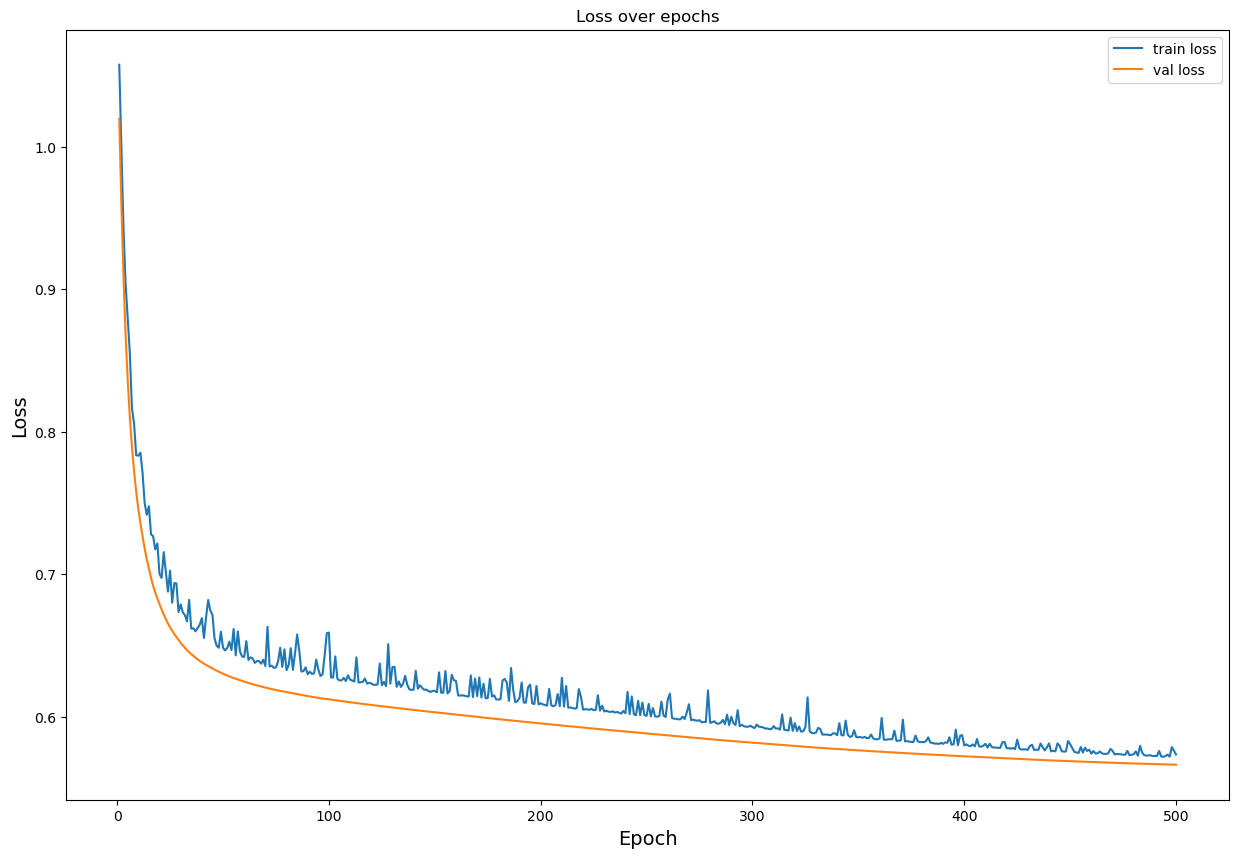

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, epochs+1), train_loss_epochs, label='train loss')
plt.plot(range(1, epochs+1), val_loss_epochs, label='val loss')
plt.xlabel("Epoch", size=14)
plt.ylabel("Loss", size=14)
plt.title("Loss over epochs")
plt.legend()
plt.show()

In [39]:
test_set = all_data['combined']['test']
parts = test_set.parts
parts_idx_map = test_set.parts_idx
loaded_part_models = []
for part in parts:
    m = models.get_model_class(part)
    m.load_state_dict(torch.load('./trained_models/{}_meta_weights.pth'.format(part)))
    loaded_part_models.append(m)



In [40]:
test_dataloader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

In [41]:
test_part_preds = []
test_benign_preds = []



model.eval()
for i in range(len(test_set)):
    image, part, binary_label = test_set.images[i], test_set.labels[i], test_set.binary_labels[i]
    with torch.no_grad():
        # Predict which body part
        x = image.unsqueeze(0)
        x_scaled = (x-pixel_means)/pixel_stds
        x_scaled = x_scaled.unsqueeze(1)
        x = x.unsqueeze(1)
        out = model.forward(x_scaled)
        y_pred = F.one_hot(torch.argmax(out, dim=1), num_classes=num_classes)

        idx = torch.argmax(y_pred).item()
        
        # Choose next model and predict if cancer or no cancer
        leaf_model = loaded_part_models[idx]
        leaf_model.eval()
        out_2 = leaf_model.forward(x)
        y2_pred = int(out_2.round().item())
        
        test_part_preds.append(y_pred)
        test_benign_preds.append(y2_pred)
        
        
        

In [42]:
test_part_preds = torch.stack(test_part_preds).squeeze(1)
test_benign_preds = torch.tensor(test_benign_preds).unsqueeze(1)

correct = (test_part_preds == test_set.labels).sum().item() / num_classes
test_acc = correct / test_set.labels.size(0)
print(test_acc)

test_acc_2 = (torch.squeeze(test_benign_preds).eq(test_set.binary_labels)).sum().item() / test_set.binary_labels.size(dim=0)
print(test_acc_2)


1.0
0.7


In [33]:
from sklearn.metrics import confusion_matrix

true_body_part_labels = torch.argmax(test_set.labels, dim=1).numpy()
pred_body_part_labels = torch.argmax(test_part_preds, dim=1).numpy()

body_part_cm = confusion_matrix(true_body_part_labels, pred_body_part_labels)

binary_preds = (test_benign_preds > 0.5).int().squeeze().numpy()
binary_labels = test_set.binary_labels.numpy()

cancer_cm_list = []
for part in range(3):
    indices = np.where(true_body_part_labels == part)
    cancer_cm = confusion_matrix(binary_labels[indices], binary_preds[indices])
    cancer_cm_list.append(cancer_cm)

cancer_cm_combined = np.sum(cancer_cm_list, axis=0)

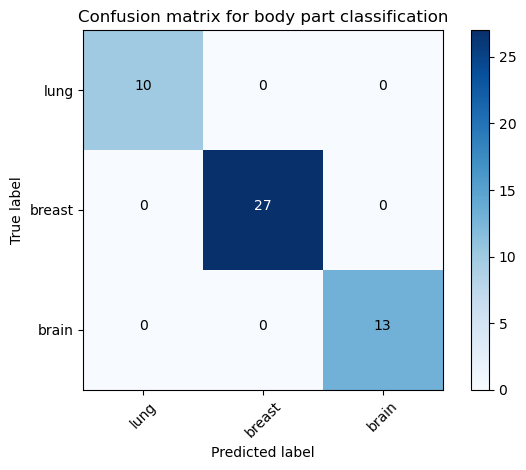

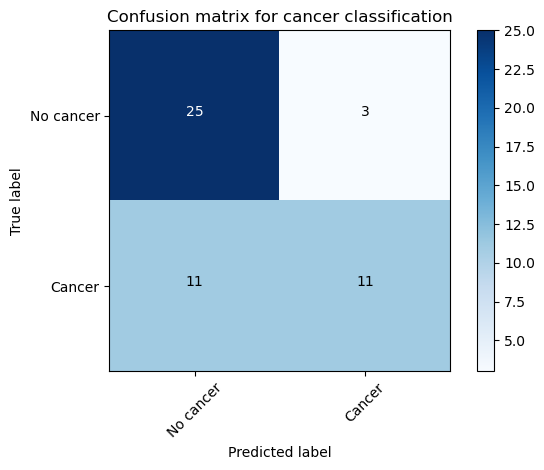

In [34]:
import itertools

def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot confusion matrix for body part classification
plt.figure()
plot_confusion_matrix(body_part_cm, classes=parts,
                      title='Confusion matrix for body part classification')
plt.show()

# Plot confusion matrix for cancer classification
plt.figure()
plot_confusion_matrix(cancer_cm_combined, classes=['No cancer', 'Cancer'],
                      title='Confusion matrix for cancer classification')
plt.show()


In [35]:
import scipy.ndimage as nd

def surfd(input1, input2, sampling=1, connectivity=1):
    
    input_1 = np.atleast_1d(input1.astype(bool))
    input_2 = np.atleast_1d(input2.astype(bool))
	
    conn = nd.generate_binary_structure(input_1.ndim, connectivity)

    S = input_1 ^ nd.binary_erosion(input_1, conn)
    Sprime = input_2 ^ nd.binary_erosion(input_2, conn)
	
    dta = nd.distance_transform_edt(~S,sampling)
    dtb = nd.distance_transform_edt(~Sprime,sampling)
    
    sds = np.concatenate([np.ravel(dta[Sprime!=0]), np.ravel(dtb[S!=0])])
        
    return sds

In [36]:
print('Precision for Body Part Classification: %.3f' % precision_score(true_body_part_labels, pred_body_part_labels, average='weighted'))
print('Recall for Body Part Classification : %.3f' % recall_score(true_body_part_labels, pred_body_part_labels, average='weighted'))
print('F1 Score (DICE Coefficient) for Body Part Classification: %.3f' % f1_score(true_body_part_labels, pred_body_part_labels, average='weighted'))
print('Mean Surface Distance for Body Part Classification %.3f'% surfd(true_body_part_labels, pred_body_part_labels).mean())
print('Cohen Kappa Score for Body Part Classification: %.3f' % cohen_kappa_score(true_body_part_labels, pred_body_part_labels))

Precision for Body Part Classification: 1.000
Recall for Body Part Classification : 1.000
F1 Score (DICE Coefficient) for Body Part Classification: 1.000
Mean Surface Distance for Body Part Classification 0.000
Cohen Kappa Score for Body Part Classification: 1.000


In [37]:

print('Precision for Cancer Classification: %.3f' % precision_score(binary_labels, binary_preds, average='weighted'))
print('Recall for Cancer Classification : %.3f' % recall_score(binary_labels, binary_preds, average='weighted'))
print('F1 Score (DICE Coefficient) for Cancer Classification: %.3f' % f1_score(binary_labels, binary_preds, average='weighted'))
print('Mean Surface Distance for Cancer Classification %.3f'% surfd(binary_labels, binary_preds).mean())
print('Cohen Kappa Score for Cancer Classification: %.3f' % cohen_kappa_score(binary_labels, binary_preds))

Precision for Cancer Classification: 0.735
Recall for Cancer Classification : 0.720
F1 Score (DICE Coefficient) for Cancer Classification: 0.706
Mean Surface Distance for Cancer Classification 1.161
Cohen Kappa Score for Cancer Classification: 0.409


In [38]:
cancer_type = ['Lung', 'Breast', 'Brain']
for p in range(3):
    indices = np.where(true_body_part_labels == p)
    cancer_labels = []
    cancer_preds=[]
    print('Precision for ' + cancer_type[p]+ ' Cancer Classification: %.3f' % precision_score(binary_labels[indices], binary_preds[indices], average='weighted', zero_division= False))
    print('Recall for  ' +cancer_type[p]+ '  Cancer Classification : %.3f' % recall_score(binary_labels[indices], binary_preds[indices], average='weighted', zero_division= False))
    print('F1 Score (DICE Coefficient) for ' + cancer_type[p]+ ' Cancer Classification: %.3f' % f1_score(binary_labels[indices], binary_preds[indices], average='weighted'))
    print('Mean Surface Distance for ' + cancer_type[p] + ' Cancer Classification %.3f'% surfd(binary_labels[indices], binary_preds[indices]).mean())
    print('Cohen Kappa Score for ' + cancer_type[p] + ' Cancer Classification: %.3f\n' % cohen_kappa_score(binary_labels[indices], binary_preds[indices]))
    

    

Precision for Lung Cancer Classification: 0.600
Recall for  Lung  Cancer Classification : 0.600
F1 Score (DICE Coefficient) for Lung Cancer Classification: 0.600
Mean Surface Distance for Lung Cancer Classification 0.600
Cohen Kappa Score for Lung Cancer Classification: 0.167

Precision for Breast Cancer Classification: 0.787
Recall for  Breast  Cancer Classification : 0.667
F1 Score (DICE Coefficient) for Breast Cancer Classification: 0.588
Mean Surface Distance for Breast Cancer Classification 3.455
Cohen Kappa Score for Breast Cancer Classification: 0.208

Precision for Brain Cancer Classification: 0.936
Recall for  Brain  Cancer Classification : 0.923
F1 Score (DICE Coefficient) for Brain Cancer Classification: 0.924
Mean Surface Distance for Brain Cancer Classification 0.200
Cohen Kappa Score for Brain Cancer Classification: 0.843

